In [1]:
## cetin ilhan kaya phys710 exam Question 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lrsch
import torch.nn.functional as funct
import torch.utils.data as data
import torchvision.transforms as trf
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import pennylane as qml
genessis = time.time()
#seed random generators
np.random.seed(31)
measure = 0
torch.cuda.manual_seed(31)

In [2]:
train_trans = trf.Compose([
                        trf.Resize(224),    
                        trf.CenterCrop(256),
                        trf.RandomRotation([-np.pi/2,np.pi/2]), 
                        trf.RandomHorizontalFlip(p=0.3),
                        trf.RandomVerticalFlip(p=0.2),
                        trf.RandomPerspective(p=0.1),
                        trf.ToTensor(),
                        trf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
                        
test_trans = trf.Compose([
                        trf.Resize(224),
                        trf.CenterCrop(256),
                        trf.ToTensor(),
                        trf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#generate loaders
train_data = datasets.ImageFolder('/data/real_fake/train/', transform=train_trans)
test_data = datasets.ImageFolder('/data/real_fake/test/', transform=test_trans)

dataloader = torch.utils.data.DataLoader(train_data,batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)


#split train data into train and validation 
n_train = int(len(train_data)*0.9)
n_valid = len(train_data) - n_train

train_data, valid_data = data.random_split(train_data, [n_train, n_valid])
valid_data = copy.deepcopy(valid_data)
#valid_data.datasets.transform = test_trans

print('training samples: ', len(train_data))
print('validation samples: ', len(valid_data))
print('test samples: ', len(test_data))

#construct iterator
batch_size = 4
train_iter = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_iter = data.DataLoader(valid_data, batch_size=batch_size)
test_iter = data.DataLoader(test_data, batch_size=batch_size)


'''trains, label = next(iter(dataloader))
tests, tlabel = next(iter(testloader))
class_names = train_data.classes'''


training samples:  619
validation samples:  69
test samples:  60


'trains, label = next(iter(dataloader))\ntests, tlabel = next(iter(testloader))\nclass_names = train_data.classes'

In [3]:
n_images = 4

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(n_images)]])

classes = test_data.classes



In [4]:

n_qubits = 4
q_depth = 6
dev = qml.device('default.qubit', wires=n_qubits)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
q_delta = 0.01
print(torch.cuda.is_available())

# quantum layers
def H_layer(nqubits):
    for i in range(nqubits):
        qml.Hadamard(wires=i) #superposing states
def RY_layer(theta_):
    for i, th in enumerate(theta_):
        qml.RY(th, wires=i) #rotating states
def entangler_layer(nqubits): # layer of cnots cross-firing. cnot[0,1]-cnot[1,2]-cnot[2,3]-...
    for i in range(0,nqubits-1, 2):  # evens
        qml.CNOT(wires=[i, i+1])
    for i in range(1,nqubits-1, 2): # odds
        qml.CNOT(wires=[i, i+1])   #entangling states
    
# variational circuit
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface='torch')

def q_net(theta, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth,n_qubits)
    H_layer(n_qubits) #superpose
    RY_layer(theta)   #embed features in qnode
    for i in range(q_depth):  #sequence of trainable variatinal layers
        entangler_layer(n_qubits)
        RY_layer(q_weights[i])
    exp_vals = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] 
    print('exp.vals = ', tuple(exp_vals))
    
    return tuple(exp_vals)

class dressedQnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.preprocess = nn.Linear(512, n_qubits)
        self.preprocess = nn.Dropout(p=0.5)
        self.thetas = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.postprocess = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        print('features: ', input_features)
        print(len(input_features[0]))
        output_pre = self.pre_net(input_features)
        theta = torch.tanh(output_pre) * np.pi / 2.0  #nonlinear activation on q.layer

        output_q = torch.Tensor(0, n_qubits)
        output_q = output_q.to(device)
        for th in theta:
            q_out = q_net(th, self.thetas).float().unsqueeze(0)
            output_q = torch.cat((output_q, q_out))

        return self.postprocess(output_q)

True


In [5]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for i in model.parameters():
    i.requires_grad=False

features = torch.randn(q_depth, 512, requires_grad=(True))
features= features.unsqueeze(1)
output_pre =dressedQnetwork()


model.fc1 = dressedQnetwork()
model = model.to(device)

cost = nn.CrossEntropyLoss() #cost function
cost = cost.to(device)
opt = optim.SGD(model.fc.parameters(), lr=0.5, momentum=0.9) #use SGD optimizer
#opt = optim.Adam(model.fc.parameters(), lr=0.0005)
lr_reduce = lrsch.StepLR(opt, 10, 0.1) #reducelearning rate by .1 for every 10 epochs

In [6]:
def best_accuracy(y_prediction, y):  #return 5 best accuracies
    with torch.no_grad():
        batch_size = y.shape[0]
        stuff, best_prediction = torch.topk(y_prediction,5,sorted=True)  #returns best prediction
        best_prediction = best_prediction.t()
        correct = best_prediction.eq(y.view(1,-1).expand_as(best_prediction))
        correct_best = correct[:1].reshape(-1).float().sum(0,keepdim=True)
        accuracy_best = correct_best/batch_size
    return accuracy_best



In [7]:
def trainer(model, iterator, optimizer, cost_function, scheduler, device): #returns loss and best epoch accuracy 
    epoch_loss = 0
    epoch_acc_best = 0
    model.train()
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_prediction = model(x)
        loss = cost(y_prediction, y)
        accuracy_best= best_accuracy(y_prediction,y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_best += accuracy_best.item()
    epoch_loss = epoch_loss/len(iterator)
    epoch_acc_best = epoch_acc_best/len(iterator)
    return epoch_loss, epoch_acc_best

def evaluator(model,iterator,cost_function, device): #returns loss and best epoch accuracy
    epoch_loss = 0
    epoch_acc_best = 0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_prediction= model(x)
            loss = cost(y_prediction, y)
            accuracy_best = best_accuracy(y_prediction,y)
            
            epoch_loss += loss.item()
            epoch_acc_best += accuracy_best.item()
    epoch_loss = epoch_loss/len(iterator)
    epoch_acc_best = epoch_acc_best/len(iterator)
    return epoch_loss, epoch_acc_best

def timer(time_begin,time_end):
    total_time = time_end - time_begin
    mins = int(total_time / 60)
    secs = total_time - mins*60
    return mins, secs


In [8]:

def test_and_train(model, epochs, cooler):
    '''args:
        cooler: [int] putting delay between epochs for giving to gpu some time to cool off. 
                useful for large databases'''
    best_loss_valid = 10000.0
    train_time=time.time()

    for param in model.parameters():
        param.requires_grad_(True)
    for i in range(epochs):
        begin_timer = time.time()
        for j in range(cooler):
            u = f'epoch #{i+1} training' + '.'*j
            print(u,end='\r')
            time.sleep(0.5)
        train_loss, train_acc= trainer(model, train_iter, opt, cost, lr_reduce, device)  
        valid_loss, valid_acc = evaluator(model, valid_iter, cost, device)
        test_loss, test_acc = evaluator(model, test_iter, cost, device)
        torch.save(model.state_dict(),'model.pt')
        if valid_loss < best_loss_valid:
            best_loss_valid = valid_loss
        end_timer = time.time()
        mins, secs = timer(begin_timer, end_timer)
        print(f'  epoch #{i+1:02}    epoch time = {mins}m {secs}s')
        print(f' train loss = {train_loss:.3f}  \n train accuracy = {train_acc*100:6.2f}% ')
        print( f' validation loss = {valid_loss:.3f} \n validation accuracy = {valid_acc*100:6.2f}% ')
        print(f'  test loss = {test_loss:.3f} \n test accuracy = {test_acc*100:6.2f}%')
    
    doomsday = time.time()
    tmin, tsec = timer(genessis, doomsday )
    fmin, fsec = timer(train_time, doomsday)
    print('\n' f'training time = {fmin}m {fsec}s')
    print(f' total time elapsed = {tmin}m {tsec}s')


In [9]:
test_and_train(model,10,3)



  epoch #01    epoch time = 0m 27.53085422515869s
 train loss = 3.624  
 train accuracy =  64.46% 
 validation loss = 2.266 
 validation accuracy =  61.11% 
  test loss = 0.312 
 test accuracy =  88.33%
  epoch #02    epoch time = 0m 25.39508891105652s
 train loss = 3.496  
 train accuracy =  65.22% 
 validation loss = 1.878 
 validation accuracy =  77.78% 
  test loss = 0.572 
 test accuracy =  81.67%
  epoch #03    epoch time = 0m 25.011696100234985s
 train loss = 3.236  
 train accuracy =  67.85% 
 validation loss = 2.092 
 validation accuracy =  72.22% 
  test loss = 0.280 
 test accuracy =  93.33%
  epoch #04    epoch time = 0m 25.423917293548584s
 train loss = 3.499  
 train accuracy =  66.51% 
 validation loss = 2.332 
 validation accuracy =  75.00% 
  test loss = 0.303 
 test accuracy =  90.00%
  epoch #05    epoch time = 0m 24.97073221206665s
 train loss = 3.303  
 train accuracy =  67.96% 
 validation loss = 1.755 
 validation accuracy =  70.83% 
  test loss = 0.366 
 test ac

In [10]:
def predictions(model,iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_prediction = model(x)
            y_prob = funct.softmax(y_prediction, dim=-1)
            best_pred = y_prob.argmax(1, keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images,dim=0)
    labels = torch.cat(labels,dim=0)
    probs = torch.cat(probs,dim=0)
    return images, labels, probs

images, labels, probs = predictions(model, test_iter)
predict_labels = torch.argmax(probs,1)
corrects = torch.eq(labels,predict_labels)
wrongs = []
for img, lbl, prob, correct in zip(images,labels,probs,corrects):
    if not correct:
        wrongs.append((img,lbl,prob))
wrongs.sort(reverse=True, key=lambda x: torch.max(x[2],dim=0).values)

5 most wrong predictions. this is most probably because the dataset has easy, medium and hard levels
i think the question you asked has different answer but as far as my database is concerned,
the most dominant cause is the difficulty level, because even i thought those pics were real


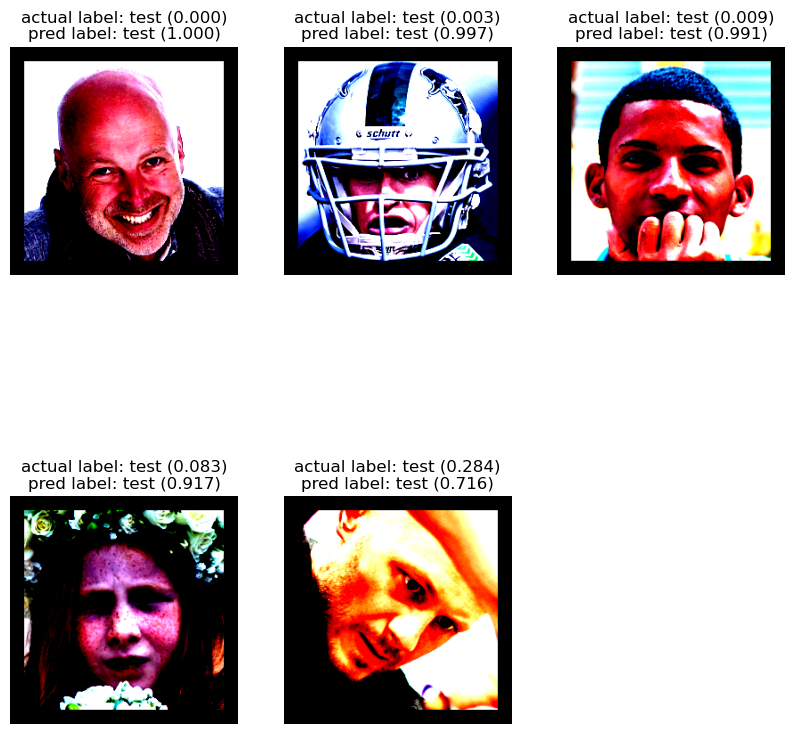

In [22]:
def plot_most_wrong(wrong, classes, n_images):
    fig = plt.figure(figsize = (10,10))
    for i in range(5):
        ax = fig.add_subplot(2, 3, i+1)
        image, real_label, probs = wrong[i]
        image = image.permute(1, 2, 0)
        real_prob = probs[real_label]
        wrong_prob, wrong_label = torch.max(probs, dim = 0)
        real_class = classes[real_label]
        wrong_class = classes[wrong_label-1]
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'actual label: {real_class} ({real_prob:.3f})\n' \
                     f'pred label: {wrong_class} ({wrong_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.4)
   
plot_most_wrong(wrongs, classes,9)

print('5 most wrong predictions. this is most probably because the dataset has easy, medium and hard levels')
print('i think the question you asked has different answer but as far as my database is concerned,')
print('the most dominant cause is the difficulty level, because even i thought those pics were real')